# Multiprecision exploration
The final part of every algorithm proposed has to compute
$$ \frac{1}{n} \sum_{i=0}^{n-1} cos(x_i) $$

in this notebook I'll explore the possibility of approximating this computation.

## Original python implementation
```python
@impl(Algorithm.RS, Backend.NUMPY, [Device.CPU], description = 'array programming implementation')
def rs(x: Tensor, y: Tensor, z: Tensor, pists: Tensor, xx: Tensor, yy: Tensor, C1: float, C2: float):
    return np.angle(
        np.mean(
            np.exp(
                1j * (
                    C1 * (x[:,ε]*xx[ε,:] + y[:,ε]*yy[ε,:]) +
                    C2 * z[:,ε] * (xx**2 + yy**2)[ε,:] +
                    2*np.pi*pists[:,ε]
                )
            ),
            axis=0
        )
    )
```

I want to understand the distribution of the arrays inside the complex exponential functions. I'll pick as spots and SLM parameters values I have found [at the original repository](https://github.com/ppozzi/SLM-3dPointCloud)

In [1]:
import numpy as np
from slmporting.core.slm import SLM
from slmporting.core.types import Backend, Device
from slmporting.utils.units import Unit, Length

In [2]:
# generate an SLM configuration according to specs
slm_to_pupil_magnification = 5.0 / 3.0

slm = SLM(
    focal = Length(180.0/20.0, Unit.MILLIMETERS),
    pixel_size = Length(slm_to_pupil_magnification * 9.2, Unit.MICROMETERS),
    wavelength = Length(800.0, Unit.NANOMETERS),
    resolution = 512,
)

/home/matteo/github/slm-porting/venv/lib/python3.12/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
# generate points uniformely distributed in a grid (same as reference)
def generate_grid_points(n: int, size):
    lin = np.linspace(-size/2, size/2, num=n)
    x, y = np.meshgrid(lin, lin)

    x = x.flatten()
    y = y.flatten()
    z = np.zeros_like(x)

    return x, y, z

In [4]:
# compute the inner parenthesis
def compute_cosine_input(x, y, z, slm: SLM):
    ε = np.newaxis
    C1 = slm.C1
    C2 = slm.C2
    xx = slm.xx.convert_to(Backend.NUMPY)
    yy = slm.yy.convert_to(Backend.NUMPY)

    return C1 * (x[:,ε]*xx[ε,:] + y[:,ε]*yy[ε,:]) + \
           C2 * z[:,ε] * (xx**2 + yy**2)[ε,:]

In [5]:
x, y, z = generate_grid_points(10, size=300.0)
cosine_input = compute_cosine_input(x, y, z, slm).flatten()

In [6]:
print(f'cosine_input.shape = {cosine_input.shape}')
print(f'cosine_input.size: {cosine_input.nbytes / 1024 / 1024:.2f} MB')

cosine_input.shape = (20501200,)
cosine_input.size: 156.41 MB


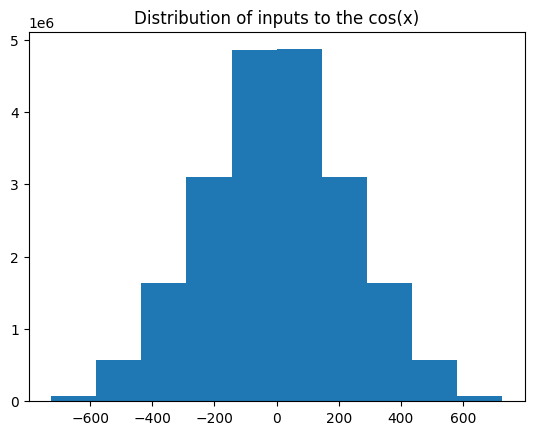

In [7]:
import matplotlib.pyplot as plt

plt.title("Distribution of inputs to the cos(x)")
plt.hist(cosine_input)
plt.show()